In [13]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import custom_model
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import shuffle
import numpy as np
import itertools, os
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model_name = 'enformer'
csv_dir = f'../results/summary_csvs/{model_name}/'
sufficient_cre_df = pd.read_csv(f'{csv_dir}/sufficient_CREs.csv')


In [50]:
sufficient_cre_df.groupby(['cell_line', 'tile class', 'context']).count()

Unnamed: 0  (MUT - CONTROL) / WT   
cell_line tile class context                                       
GM12878   Enhancer   enhancing          41                    41  \
          Silencer   silencing          57                    57   
K562      Enhancer   enhancing          74                    74   
          Silencer   silencing         222                   222   
PC-3      Enhancer   enhancing          35                    35   
          Silencer   silencing          97                    97   

                                (MUT - CONTROL) / CONTROL  seq_id  control   
cell_line tile class context                                                 
GM12878   Enhancer   enhancing                         41      41       41  \
          Silencer   silencing                         57      57       57   
K562      Enhancer   enhancing                         74      74       74   
          Silencer   silencing                        222     222      222   
PC-3      Enhancer   enhancing                         35      35       35   
          Silencer   silencing                         97      97       97   

                                 wt  mut  tile_start  tile_end   
cell_line tile class context                                     
GM12878   Enhancer   enhancing   41   41          41        41  \
          Silencer   silencing   57   57          57        57   
K562      Enhancer   enhancing   74   74          74        74   
          Silencer   silencing  222  222         222       222   
PC-3      Enhancer   enhancing   35   35          35        35   
          Silencer   silencing   97   97          97        97   

                                Normalized CRE effect  
cell_line tile class context                           
GM12878   Enhancer   enhancing                     41  
          Silencer   silencing                     57  
K562      Enhancer   enhancing                     74  
          Silencer   silencing                    222  
PC-3      Enhancer   enhancing                     35  
          Silencer   silencing                     97

In [138]:
res.keys()

dict_keys(['only_tss_pred', 'tss_and_cre_pred', 'best_tss_signal', 'selected_tile_order', 'all_mutants'])

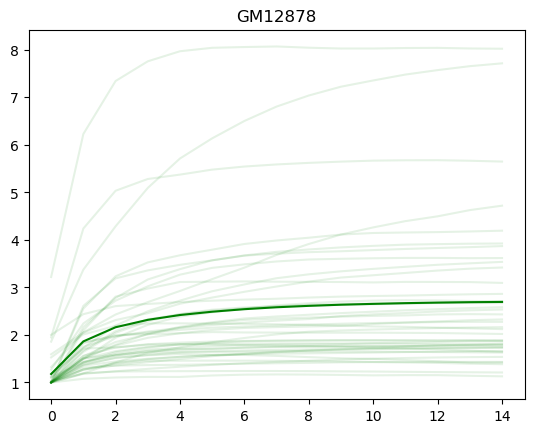

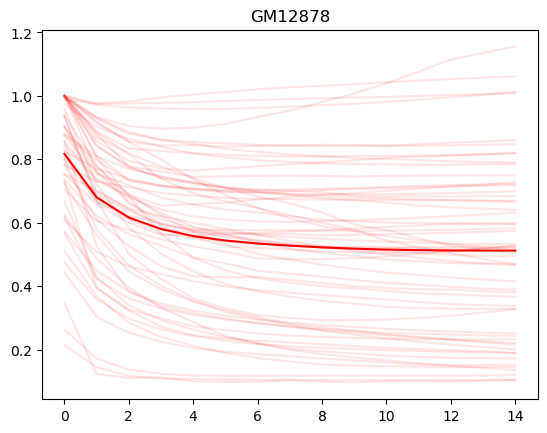

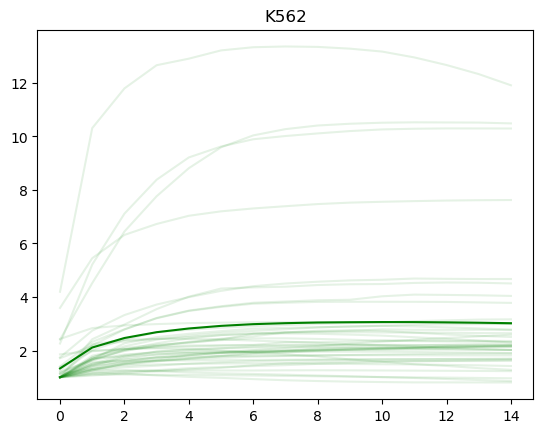

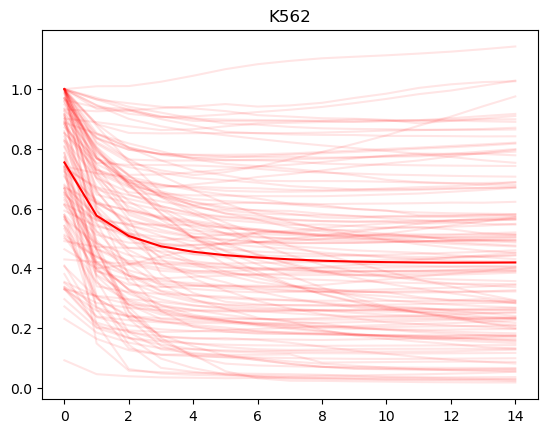

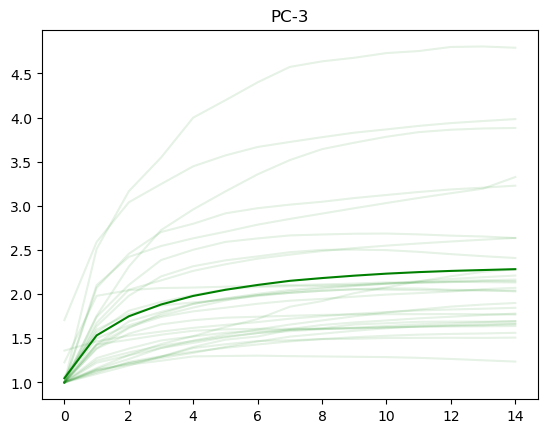

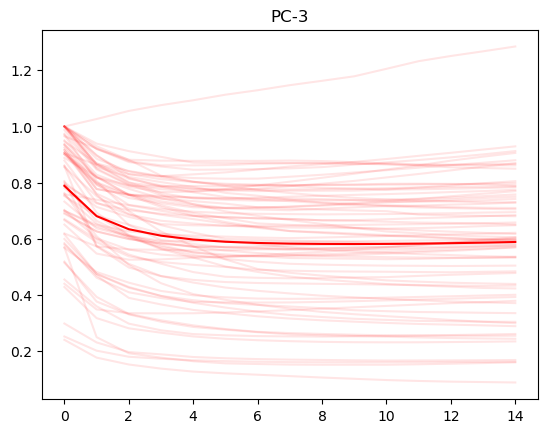

In [144]:
for (cell, tile_type), df in sufficient_cre_df.groupby(['cell_line', 'tile class']):
    tss_activity = []
    if tile_type == 'Enhancer':
        c = 'g'
    else:
        c = 'r'
    for i, row in df.iterrows():
        result_path = f'../results/multiplicity_test/{model_name}/{cell}/{row["seq_id"]}_tile_start_{row["tile_start"]}_tile_end_{row["tile_end"]}.pickle'
        # assert os.path.isfile(result_path), f'File {result_path} not found'
        if os.path.isfile(result_path):
            res = utils.read_pickle(result_path)
            v = np.array(res['best_tss_signal']) / res['tss_and_cre_pred']
            plt.plot(v, alpha=0.1, color=c)
            tss_activity.append(v)
    mean_tss = np.array(tss_activity).mean(axis=0)
    plt.plot(mean_tss, color=c)
    # plt.ylim(0, 4)
    plt.title(cell)
    plt.show()


In [36]:
res['max_per_iter'][0][0] 

1.3787251710891724

In [4]:
silencers = sufficient_cre_df[(sufficient_cre_df['tile class'] == 'Silencer') & (sufficient_cre_df['cell_line'] == 'K562')]

In [5]:
row = silencers.iloc[0]

In [6]:
model = custom_model.Enformer(track_index=5111, bin_index=[447, 448])

2023-12-27 17:52:31.479958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 17:52:31.835442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79005 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [7]:
tss_tile, cre_tiles = utils.set_tile_range(model.seq_length, 5000)


In [8]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)


In [9]:
seq_id = row['seq_id']
chrom, start, strand = seq_id.split('_')[1:]


In [10]:
seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length, onehot=True)

In [11]:
cre_seq = seq[row['tile_start']: row['tile_end'], :].copy()

In [67]:
x = seq.copy()
tss_tile_coord = tss_tile
cre_tile_coord = [row['tile_start'], row['tile_end']]
cre_tile_seq = cre_seq 
test_coords = cre_tiles.copy()
num_shuffle = 2
num_copies = 3
optimization = np.argmin

In [ ]:
window_size = 5000

In [81]:
shuffled_seqs = shuffle.dinuc_shuffle(x, num_shuffle)  # destroy all
shuffled_seqs[:, tss_tile_coord[0]:tss_tile_coord[1], :] = x[tss_tile_coord[0]:tss_tile_coord[1], :].copy()

only_tss_pred = model.predict(shuffled_seqs).mean()

tss_and_cre = shuffled_seqs.copy()
tss_and_cre[:, row['tile_start']: row['tile_end']] = cre_tile_seq

tss_and_cre_pred = model.predict(tss_and_cre).mean()


tile_positions_to_test = cre_tiles.copy()
current_seq_version = shuffled_seqs.copy()
all_mutants = []
best_tss_signal = []
selected_tile_order = []
for i in tqdm(range(num_copies)):
    test_seqs = np.empty((num_shuffle, len(tile_positions_to_test), model.seq_length, 4))
    mutant_preds = np.empty((num_shuffle, len(tile_positions_to_test)))
    for s, shuffled_seq in enumerate(current_seq_version):
        for t, (tile_start, tile_end) in enumerate(tile_positions_to_test):
            test_seq = shuffled_seq.copy()
            test_seq[tile_start: tile_end] = cre_seq.copy()
            mutant_preds[s, t] = model.predict(test_seq).mean()
            test_seqs[s, t, ...] = test_seq.copy()
    best_index = mutant_preds.mean(axis=0).argmin()
    selected_tile = tile_positions_to_test[best_index]
    best_tss_signal.append(mutant_preds.mean(axis=0).min())
    tile_positions_to_test.remove(selected_tile)
    selected_tile_order.append(selected_tile)
    all_mutants.append(mutant_preds)
    current_seq_version = test_seqs[:, best_index, ...].copy()

In [125]:
mutant_preds.mean(axis=0)[best_index]

6.718322038650513

In [127]:
res = creme.multiplicity_test(model, x, tss_tile, [row['tile_start'], row['tile_end']], 
                        cre_seq, cre_tiles, 2, 3,
                      np.argmin)

100%|████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.35s/it]


In [133]:
res['all_mutants'][0].mean(axis=0).min()

6.112009286880493

In [89]:
best_tss_signal

[7.46332859992981, 6.882856607437134, 6.718322038650513]

In [107]:
(current_seq_version[0].argmax(-1)[100804: 105804] == x.argmax(-1)[105804: 105804+5000]).all()

True

In [103]:
row['tile_start']

105804

In [94]:
selected_tile_order

[[100804, 105804], [120804, 125804], [90804, 95804]]

In [114]:
res = utils.read_pickle(f"../results/multiplicity_test/enformer/K562/{row['seq_id']}_tile_start_{row['tile_start']}_tile_end_{row['tile_end']}.pickle")

In [113]:
selected_tile_order

[[100804, 105804], [120804, 125804], [90804, 95804]]

In [122]:
res['max_per_iter'][2].mean()


0.7975701808929443